<a href="https://colab.research.google.com/github/MEskerod/RNA_UNET/blob/main/experiments/RNAUnet_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle, sys, torch, tarfile, os

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd

from collections import namedtuple

In [3]:
sys.path.append('/content/drive/MyDrive')
import utils

# Functions

In [4]:
class RNA_Unet(nn.Module):
    def __init__(self, channels=32, in_channels=8, output_channels=1, negative_slope = 0.01, pooling = utils.MaxPooling):
        """
        Pytorch implementation of a Unet for RNA secondary structure prediction

        Parameters:
        - channels (int): number of channels in the first hidden layer.
        - in_channels (int): number of channels in the input layer
        - output_channels (int): number of channels in the output layer
        - negative_slope (float): negative slope for the LeakyReLU activation function
        - pooling (nn.Module): the pooling layer to use
        """
        super(RNA_Unet, self).__init__()

        self.negative_slope = negative_slope

        #Add padding layer to make input size compatible with the Unet
        self.pad = utils.DynamicPadLayer(2**4)

        # Encoder
        self.e1 = nn.Sequential(
           nn.Conv2d(in_channels, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool1 = pooling(channels, channels, kernel_size=2, stride=2)

        self.e2 = nn.Sequential(
            nn.Conv2d(channels, channels*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*2),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*2),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool2 = pooling(channels*2, channels*2, kernel_size=2, stride=2)

        self.e3 = nn.Sequential(
            nn.Conv2d(channels*2, channels*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*4),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*4),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool3 = pooling(channels*4, channels*4, kernel_size=2, stride=2)

        self.e4 = nn.Sequential(
            nn.Conv2d(channels*4, channels*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*8),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*8),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool4 = pooling(channels*8, channels*8, kernel_size=2, stride=2)

        self.e5 = nn.Sequential(
            nn.Conv2d(channels*8, channels*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*16),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*16, channels*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*16),
            nn.LeakyReLU(negative_slope=negative_slope),
        )

        #Decoder
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(channels*16, channels*8, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels*8),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d1 = nn.Sequential(
           nn.Conv2d(channels*16, channels*8, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*8),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*8),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(channels*8, channels*4, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels*4),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d2 = nn.Sequential(
           nn.Conv2d(channels*8, channels*4, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*4),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*4),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(channels*4, channels*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels*2),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d3 = nn.Sequential(
           nn.Conv2d(channels*4, channels*2, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*2),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*2),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(channels*2, channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d4 = nn.Sequential(
           nn.Conv2d(channels*2, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.out = nn.Sequential(nn.Conv2d(channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", self.negative_slope)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2] #Keep track of the original dimension of the input to remove padding at the end
        x = self.pad(x)

        #Encoder
        xe1 = self.e1(x)
        xp1 = self.pool1(xe1)

        xe2 = self.e2(xp1)
        xp2 = self.pool2(xe2)

        xe3 = self.e3(xp2)
        xp3 = self.pool3(xe3)

        xe4 = self.e4(xp3)
        xp4 = self.pool4(xe4)

        xe5 = self.e5(xp4)

        #Decoder
        xu1 = self.upconv1(xe5)
        xu11 = torch.cat([xu1, xe4], dim=1)
        xd1 = self.d1(xu11)

        xu2 = self.upconv2(xd1)
        xu22 = torch.cat([xu2, xe3], dim=1)
        xd2 = self.d2(xu22)

        xu3 = self.upconv3(xd2)
        xu33 = torch.cat([xu3, xe2], dim=1)
        xd3 = self.d3(xu33)

        xu4 = self.upconv4(xd3)
        xu44 = torch.cat([xu4, xe1], dim=1)
        xd4 = self.d4(xu44)

        out = self.out(xd4)

        out = out[:, :, :dim, :dim]

        return out

# Data

In [5]:
RNA_data = namedtuple('RNA_data', 'input output length family name pairs')

In [6]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/data/experiment8.tar.gz'


# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall('/content')

file_list = [os.path.join('data', 'experiment8', file) for file in os.listdir('data/experiment8')]

In [7]:
train = pickle.load(open('/content/drive/MyDrive/data/experiment_train.pkl', 'rb'))
valid = pickle.load(open('/content/drive/MyDrive/data/experiment_valid.pkl', 'rb'))

family_map = pickle.load(open('/content/drive/MyDrive/data/experiment_familymap.pkl', 'rb'))

In [8]:
# Define your train_dataset and validation_dataset
train_dataset = utils.ImageToImageDataset(train, family_map)
validation_dataset = utils.ImageToImageDataset(valid, family_map)

# Compare

In [9]:
df = pd.DataFrame(columns=["Training_loss", "Training_f1", "Validation_loss", "Validation_f1"])

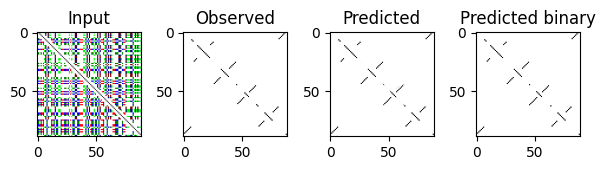

Epoch [1/10], Loss: 0.0051, Validation: 0.003


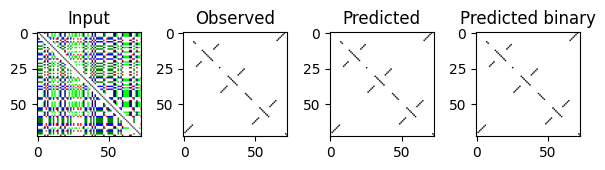

Epoch [2/10], Loss: 0.0026, Validation: 0.0025


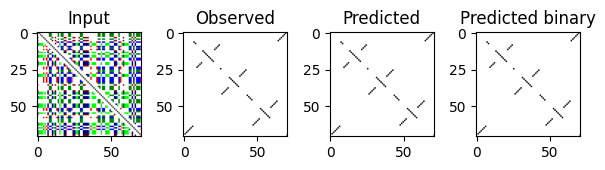

Epoch [3/10], Loss: 0.002, Validation: 0.0021


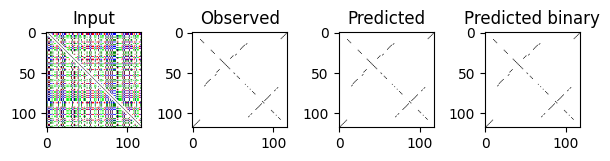

Epoch [4/10], Loss: 0.0016, Validation: 0.0018


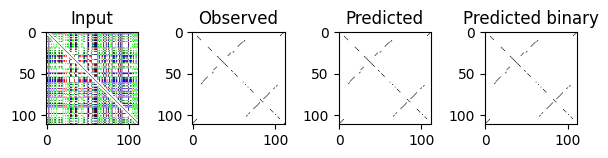

Epoch [5/10], Loss: 0.0014, Validation: 0.0017


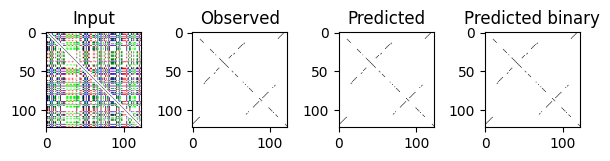

Epoch [6/10], Loss: 0.0012, Validation: 0.0016


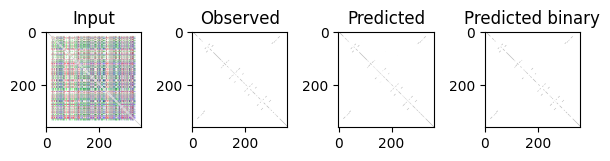

Epoch [7/10], Loss: 0.001, Validation: 0.0017


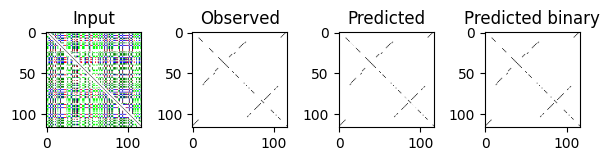

Epoch [8/10], Loss: 0.0009, Validation: 0.0016


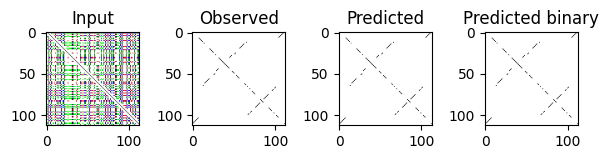

Epoch [9/10], Loss: 0.0008, Validation: 0.0016


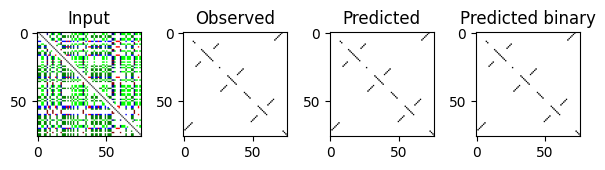

Epoch [10/10], Loss: 0.0008, Validation: 0.0017


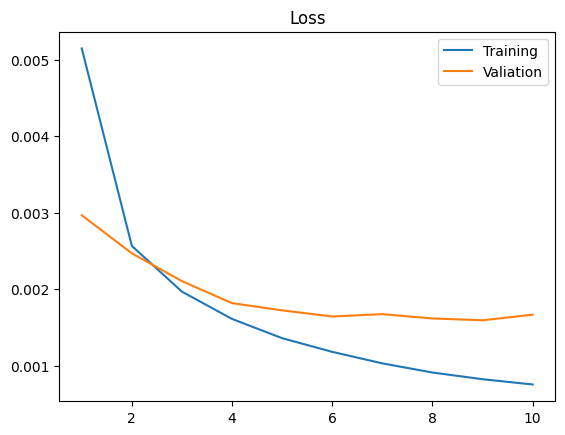

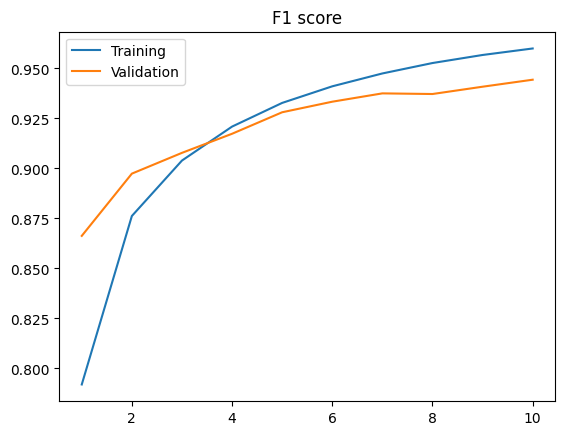

In [11]:
model = utils.RNA_Unet(channels=32)

train_loss, train_f1, valid_loss, valid_f1, _ = utils.fit_model(
    model,
    train_dataset,
    validation_dataset,
    epochs=10,
    lr = 0.01
    #plots = False
    )

df.loc["Baseline"] = [train_loss, train_f1, valid_loss, valid_f1]

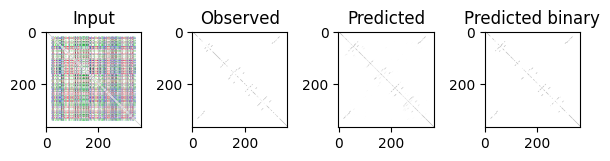

Epoch [1/10], Loss: 0.1346, Validation: 0.0969


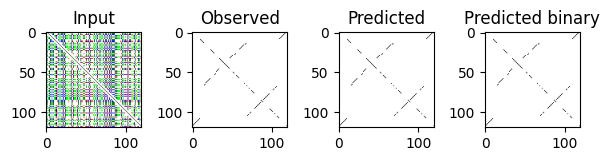

Epoch [2/10], Loss: 0.082, Validation: 0.0752


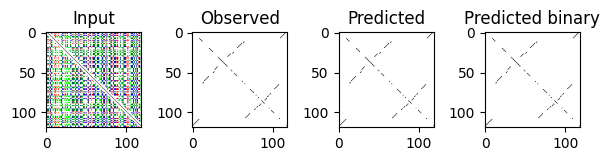

Epoch [3/10], Loss: 0.0649, Validation: 0.0631


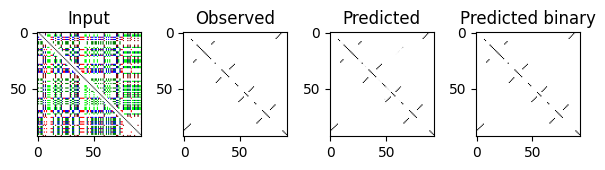

Epoch [4/10], Loss: 0.0546, Validation: 0.0556


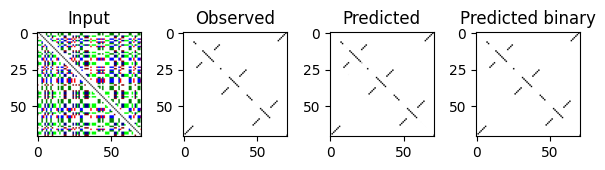

Epoch [5/10], Loss: 0.0477, Validation: 0.0509


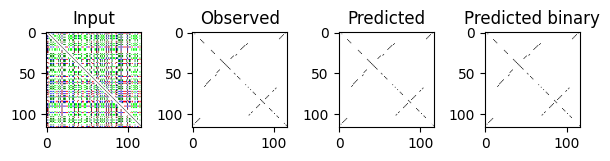

Epoch [6/10], Loss: 0.043, Validation: 0.0491


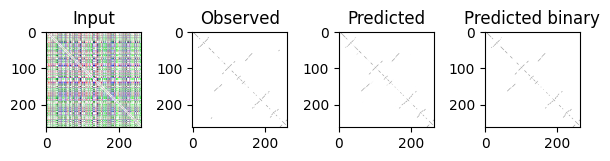

Epoch [7/10], Loss: 0.039, Validation: 0.0464


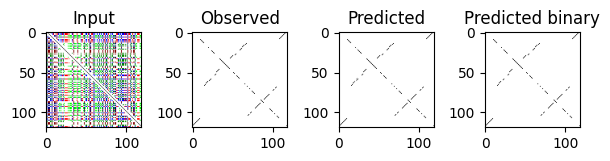

Epoch [8/10], Loss: 0.0359, Validation: 0.0423


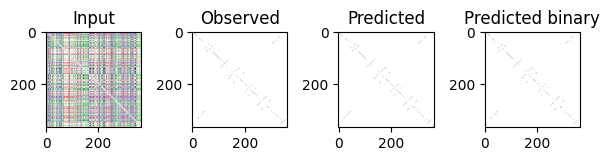

Epoch [9/10], Loss: 0.0333, Validation: 0.0408


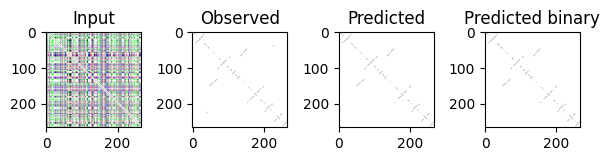

Epoch [10/10], Loss: 0.031, Validation: 0.0399


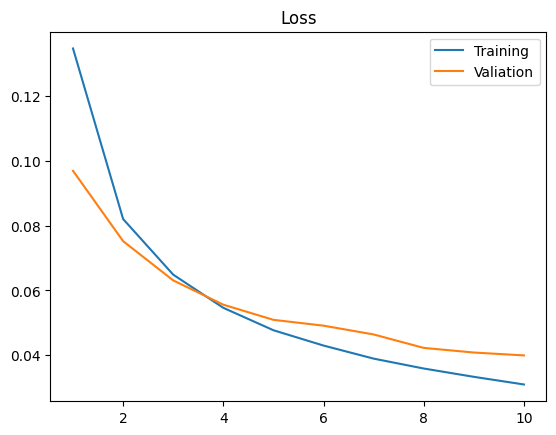

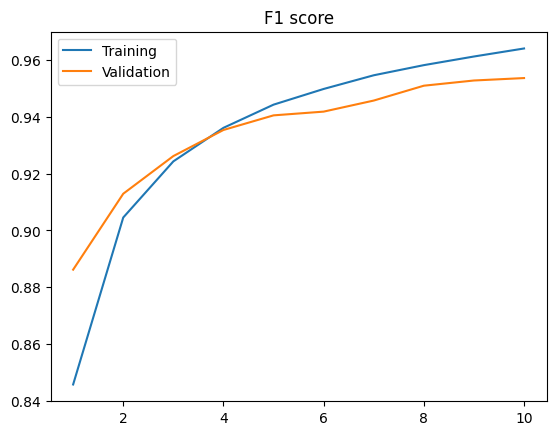

In [12]:
model = RNA_Unet()

train_loss, train_f1, valid_loss, valid_f1, _ = utils.fit_model(
    model,
    train_dataset,
    validation_dataset,
    epochs=10,
    lr = 0.01,
    loss_func = utils.dice_loss
    #plots = False
    )

df.loc["Improved"] = [train_loss, train_f1, valid_loss, valid_f1]

In [22]:
df.to_csv('/content/drive/MyDrive/results/RNAunet_comparison.csv', index=True)

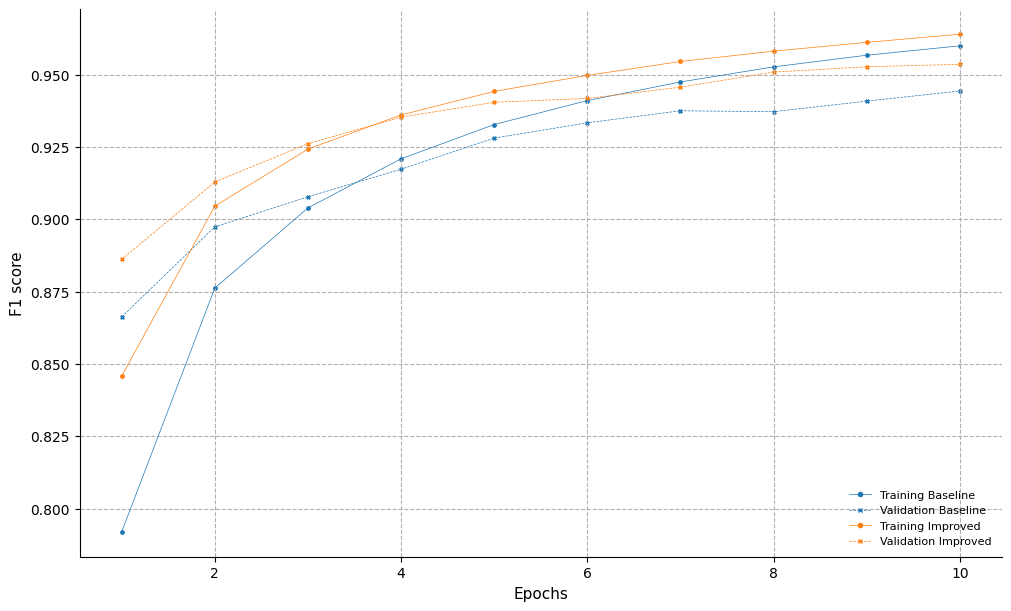

In [20]:
utils.plot_f1_curves(df, output_file = '/content/drive/MyDrive/figures/RNAunet_comparison.png')